In [1]:
from collections import defaultdict
from gtfslib.dao import Dao
from gtfslib.model import CalendarDate, Route, Stop, Trip
from itertools import tee
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline


def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2,s3), ..."
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

def label(k):
    a, b = k
    aname = dao.stop(a).stop_name
    bname = dao.stop(b).stop_name
    return "{}\n{}".format(aname, bname)

In [2]:
dao = Dao()
# http://transitfeeds.com/p/sfmta/60/20170629
dao.load_gtfs("./data/SFMTA-mission-corridor.zip")

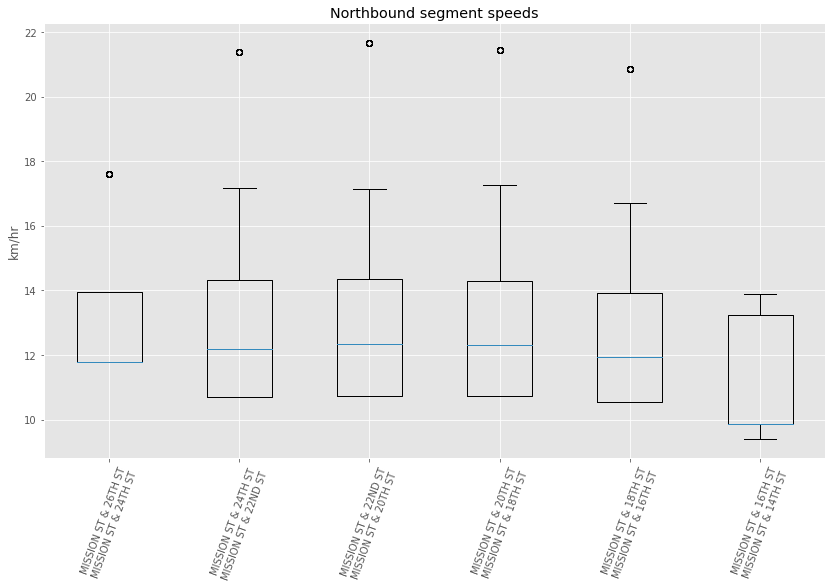

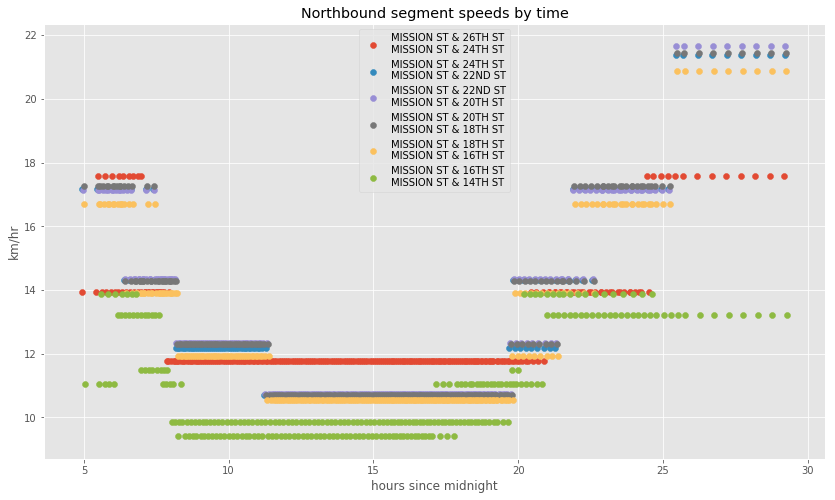

In [3]:
fltr = (
    # Pick trips scheduled for a specific date
    (CalendarDate.date=="2017-08-09")
    & ((Route.route_short_name.in_(["14","49"])) & (Trip.direction_id=="1"))
)

trips = list(dao.trips(fltr=fltr))

stop_fltr = Stop.stop_id.in_([
    # Mission corridor stop_id's
    '5547', '5551', '5553', '5557', '5561', '5565', '5567'
])

corridor = {s.stop_id for s in dao.stops(fltr=stop_fltr)}

runtimes = defaultdict(lambda: defaultdict(list))
for trip in trips:
    for a, b in pairwise(st for st in trip.stop_times if st.stop_id in corridor):
        atime = a.departure_time or a.arrival_time
        btime = b.arrival_time or b.departure_time
        seconds = btime - atime
        meters = b.shape_dist_traveled - a.shape_dist_traveled
        kph = (meters / 1000.) / (seconds / 60. / 60.)
        key = (a.stop_id, b.stop_id)
        runtimes[key]['t'].append(atime)
        runtimes[key]['kph'].append(kph)

keys = list(sorted(runtimes.keys(), key=lambda k: min(runtimes[k]['t'])))

plt.figure(figsize=(14,8))
plt.title("Northbound segment speeds")
plt.boxplot([np.array(runtimes[key]['kph']) for key in keys])
plt.ylabel("km/hr")
plt.xticks(list(range(1, len(keys) + 1)),
           list(map(label, keys)),
           rotation=70)

plt.figure(figsize=(14,8))
plt.title("Northbound segment speeds by time")
plt.ylabel("km/hr")
plt.xlabel("hours since midnight")
for key in keys:
    hours = np.array(runtimes[key]['t']) / 60. / 60.
    plt.scatter(hours, runtimes[key]['kph'])
plt.legend([label(key) for key in keys], loc=9)

plt.show()

Did you enjoy this post? Let me know on [twitter](https://twitter.com/invisiblefunnel). Also, Remix is [hiring](https://www.remix.com/jobs).